### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
import lightgbm as lightgbmclassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage
import tensorflow as tf
from sklearn import linear_model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv1D, BatchNormalization, AveragePooling1D, Reshape
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
!{sys.executable} -m pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.4 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get Updated clean and split files

In [ ]:
def get_train_test(tr = 'X_train.csv', te = 'X_test_all.csv'):
    # Returns a sample of original dataset
    # of 100k records of class 0 and all records of class 1
    # along with val and test datasets
    df = pd.read_csv(folder + tr)
    # test_df = pd.read_csv(folder + 'X_test.csv')
    test_all_df = pd.read_csv(folder + te)
    # Splitting for train and val
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                    df.target,
                                                    test_size=0.2, 
                                                    random_state=RAND_STATE,
                                                    stratify = df['target'])
    X_test_all = test_all_df.iloc[:, 3:]
    
    class_dict = {0 : 100000,
                  1 :  y_train.value_counts()[1]}
    
    rus = RandomUnderSampler(sampling_strategy = class_dict,
                             random_state = RAND_STATE) 
    X_res, y_res = rus.fit_resample(X_train, y_train)
    X_res.to_csv(folder+'charan/X_res.csv')
    y_res.to_csv(folder+'charan/y_res.csv')
    
    del df, test_all_df
#   return X_train, X_val, y_train, y_val, X_test_all
    return X_res, X_val, y_res, y_val, X_test_all

### Model Training

In [ ]:
num_preds = 5
model = Sequential()
model.add(Conv1D(32,num_preds,strides=num_preds, 
                 activation='elu', input_shape=(800, 1)))
model.add(BatchNormalization())
model.add(Conv1D(24,1, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(16,1, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(8,1, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(4,1,  activation='elu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 160, 32)           192       
                                                                 
 batch_normalization_25 (Bat  (None, 160, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_26 (Conv1D)          (None, 160, 24)           792       
                                                                 
 batch_normalization_26 (Bat  (None, 160, 24)          96        
 chNormalization)                                                
                                                                 
 conv1d_27 (Conv1D)          (None, 160, 16)           400       
                                                                 
 batch_normalization_27 (Bat  (None, 160, 16)         

In [ ]:
model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=7, validation_split=0.1)

Epoch 1/7
4500/4500 [==============================] - 145s 32ms/step - loss: 0.3198 - auc_5: 0.6121 - val_loss: 0.2990 - val_auc_5: 0.6878
Epoch 2/7
4500/4500 [==============================] - 120s 27ms/step - loss: 0.2934 - auc_5: 0.7312 - val_loss: 0.2803 - val_auc_5: 0.7559
Epoch 3/7
4500/4500 [==============================] - 122s 27ms/step - loss: 0.2778 - auc_5: 0.7743 - val_loss: 0.2683 - val_auc_5: 0.7851
Epoch 4/7
4500/4500 [==============================] - 124s 28ms/step - loss: 0.2694 - auc_5: 0.7927 - val_loss: 0.2631 - val_auc_5: 0.7986
Epoch 5/7
4500/4500 [==============================] - 124s 28ms/step - loss: 0.2647 - auc_5: 0.8022 - val_loss: 0.2577 - val_auc_5: 0.8078
Epoch 6/7
4500/4500 [==============================] - 125s 28ms/step - loss: 0.2619 - auc_5: 0.8074 - val_loss: 0.2598 - val_auc_5: 0.8123
Epoch 7/7
4500/4500 [==============================] - 127s 28ms/step - loss: 0.2599 - auc_5: 0.8111 - val_loss: 0.2537 - val_auc_5: 0.8146


In [ ]:
final_pred = model.predict(X_test)
final_pred[:5,0]

array([0.04518971, 0.02147689, 0.06186846, 0.15808386, 0.04738858],
      dtype=float32)

In [ ]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = final_pred
sub_df.to_csv("MSBA6420.Session002.submissionV2_NN.csv", index=False)

In [ ]:
final_pred

array([[0.12272945],
       [0.03403002],
       [0.15468013],
       ...,
       [0.03434604],
       [0.01749149],
       [0.02440706]], dtype=float32)

In [ ]:
# inputs model, X_val and y_val to plot RoC curve
def plot_roc(model, X_val, y_val):
    # calculate the fpr and tpr for 
    # all thresholds of the classification
    preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

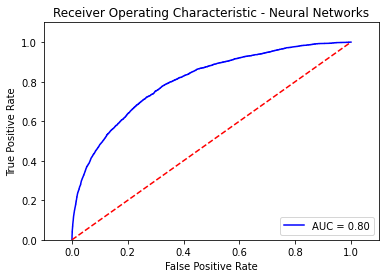

In [ ]:
plot_roc(model, X_val, y_val)